In [69]:
import torch
import torchvision
from torchvision import transforms
from tqdm import trange
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import imshow, imsave

In [70]:
mnist = torchvision.datasets.MNIST(
    root = "./data", train = True, transform = torchvision.transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5],std=[.5])
    ])
)

In [71]:
data_loader = DataLoader(dataset=mnist, batch_size=64, 
                         shuffle=True, drop_last=True)

6


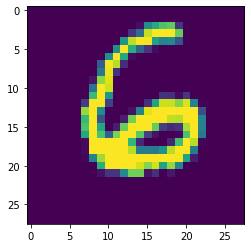

In [72]:
for i,(a,b) in enumerate(data_loader):
    plt.imshow(a[0].reshape(28,28))
    print(b[0].item())
    break

In [73]:
class Discriminator(torch.nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(input_size, 512),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(512, 256),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(256, num_classes),
            torch.nn.Sigmoid(),
        )
    
    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

In [74]:
class Generator(torch.nn.Module):
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(input_size,128),
            torch.nn.LeakyReLU(.2),
            torch.nn.Linear(128,256),
            torch.nn.BatchNorm1d(256),
            torch.nn.LeakyReLU(.2),
            torch.nn.Linear(256,512),
            torch.nn.BatchNorm1d(512),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(512, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(1024, num_classes),
            torch.nn.Tanh()
        )
    def forward(self,x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0),1,28,28)
        return y_

In [83]:
n_noise = 100
n_critic = 1
step = 0
import os
if not os.path.exists('samples'):
    os.makedirs('samples')

In [84]:

def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to('cuda')
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [85]:
D = Discriminator().to('cuda')
G = Generator(n_noise).to('cuda')

In [86]:
loss_function = torch.nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr = 0.0002, betas=(.5,.999))
G_opt = torch.optim.Adam(G.parameters(), lr = 0.0002, betas=(.5,.999))

In [87]:
D_labels = torch.ones(64,1).to('cuda')
D_fakes = torch.zeros(64,1).to('cuda')

In [88]:
batch_size=64

MODEL_NAME = 'VanillaGAN'
epochs = 20
for epoch in (l := trange(epochs)):
    for _, (images, _) in enumerate(data_loader):
        x = images.to('cuda')
        x_outputs = D(x)
        D_x_loss = loss_function(x_outputs, D_labels)
        
        z = torch.randn(64, n_noise).to('cuda')
        z_outputs = D(G(z))
        D_z_loss = loss_function(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()
        
        if step % n_critic == 0:
            z = torch.randn(batch_size, n_noise).to('cuda')
            z_outputs = D(G(z))
            G_loss = loss_function(z_outputs, D_labels)
            
            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        l.set_description('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, epochs, step, D_loss.item(), G_loss.item()))
        
        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        
        step += 1

Epoch: 19/20, Step: 18739, D Loss: 1.3729674816131592, G Loss: 0.8601198196411133: 100%|██████████| 20/20 [17:04<00:00, 51.23s/it] 
